## Importing the libraries

In [1]:
import os
import random
from collections import defaultdict
from timeit import default_timer as timer

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from loguru import logger
from torch.distributions.normal import Normal
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import os, pickle
import copy
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/himanshus/miniconda3/envs/mtl/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tracker = {"train":{}, "test":{}}
experiment = "cs_with_nc_alpha"

## Reading the Dataset

In [3]:
class TsDS(Dataset):
    def __init__(self, XL,yL,flatten=False,lno=None,long=True):
        self.samples=[]
        self.labels=[]
        self.flatten=flatten
        self.lno=lno
        self.long=long
        self.scaler = StandardScaler()
        for X,Y in zip(XL,yL):
            self.samples += [torch.tensor(X).float()]
            self.labels += [torch.tensor(Y)]
            
    def __len__(self):
        return sum([s.shape[0] for s in self.samples])

    def __getitem__(self, idx):
        if self.flatten: sample=self.samples[idx].flatten(start_dim=1)
        else: sample=self.samples[idx]
        if self.lno==None: label=self.labels[idx]
        elif self.long: label=self.labels[idx][:,self.lno].long()
        else: label=self.labels[idx][:,self.lno].float()
        return (sample,label)

    def fit(self,kind='seq'):
        if kind=='seq':
            self.lastelems=[torch.cat([s[:,-1,:] for s in self.samples],dim=0)]
            self.scaler.fit(torch.cat([le for le in self.lastelems],dim=0))            
        elif kind=='flat': self.scaler.fit(torch.cat([s for s in self.samples],dim=0))
    def scale(self,kind='flat',scaler=None):
        self.fit(kind)
        def cs(s):
            return (s.shape[0]*s.shape[1],s.shape[2])
        if scaler==None: scaler=self.scaler
        if kind=='seq':
            self.samples=[torch.tensor(scaler.transform(s.reshape(cs(s))).reshape(s.shape)).float() for s in self.samples]
            pass
        elif kind=='flat':
            self.samples=[torch.tensor(scaler.transform(s)).float() for s in self.samples]
    def unscale(self,kind='flat',scaler=None):
        def cs(s):
            return (s.shape[0]*s.shape[1],s.shape[2])
        if scaler==None: scaler=self.scaler
        if kind=='seq':
            self.samples=[torch.tensor(scaler.inverse_transform(s.reshape(cs(s))).reshape(s.shape)).float() for s in self.samples]
            pass
        elif kind=='flat':
            self.samples=[torch.tensor(scaler.inverse_transform(s)).float() for s in self.samples]

In [4]:
def get_numbers(name):
    splitted = name.split('_')
    g, d = (splitted[2]), int(splitted[3])
    return g, d

### Combining the dataset

In [5]:
folder_path = os.path.join("marketdata")
l = os.listdir(folder_path)

data_type = "cs"
meta_train = {"train": [], "test": []}
meta_test = {"train": [], "test": []}
kind = "seq" if data_type == "ds" else "flat"

for file in l:
    if data_type in file:
        type_ = "train" if "train" in file else "test"
        g, d = get_numbers(file)
        if d < 20: # for meta-training
            meta_train[type_].append(file)
        else: # for meta-testing
            meta_test[type_].append(file)


meta_train["train"] = sorted(meta_train["train"])
meta_train["test"] = sorted(meta_train["test"])

data = list(zip(meta_train["train"], meta_train["test"]))
data = sorted(data, key=lambda x: get_numbers(x[0])[1])
idx = 0

In [6]:
def load_task(task):
    """
    task is a tuple of strings of the form (train_cs_g_d_2.pkl, test_cs_g_d_2.pkl)
    returns X_train, y_train, X_test, y_test
    """
    train_file, test_file = task
    # print(train_file)
    train_data = pickle.load(open(os.path.join(folder_path, train_file), "rb"))
    test_data = pickle.load(open(os.path.join(folder_path, test_file), "rb"))
    train_data.scale(kind)
    test_data.scale(kind)
    # print(train_data, test_data)
    return train_data.samples, train_data.labels, test_data.samples, test_data.labels

def sample_task():
    """
    Returns a task
    """
    global idx
    if idx >= len(data):
        idx = 0
    task = data[idx]
    idx += 1
    
    return load_task(task)

### Adding an accumulator to keep track of the metrics

In [7]:
class Accumulator:
    def __init__(self):
        self.clear()

    def clear(self):
        self.metrics = defaultdict(lambda: [])

    def add(self, key, value):
        self.metrics[key] += value

    def add_dict(self, dict):
        for key, value in dict.items():
            self.add(key, value)

    def mean(self, key):
        return np.mean(self.metrics[key])

    def __getitem__(self, item):
        return self.metrics[item]

    def __setitem__(self, key, value):
        self.metrics[key] = value

    def get_dict(self):
        return copy.deepcopy(dict(self.metrics))

    def items(self):
        return self.metrics.items()

    def __str__(self):
        return str(dict(self.metrics))

## Args

In [8]:
demo = False
gpu = '0'
batch_size = 32
lr = 0.0005
time_budget = 10000000000.0
task = 'cs'
nc_regularize = True
epochs = 2 if demo else 10
train_steps = 2 if demo else 20
log_steps = 1
test_steps = 5
learn_freq = 10
inner_lr = 0.005
inner_steps = 5 if demo else 10
nc_weight = 1.0
learner_layers = 2
learner_hidden = 30
learner_act = 'relu'
input = 'cross_att'
enc = 'fc'
pool = 'mean'
dec = 'fc'
enc_depth = 5
dec_depth = 5
hid_dim = 512
num_heads = 8
model_path = "result/model_{}.ckpt".format(experiment)

xtrain_dim = 23 if task == 'cs' else 360
train_pred_dim = 22
y_train_dim = 10
y_train_ohe_dim = 22
train_loss_dim = 10
bilinear_output_dim = 256

best_loss_train = 10000
best_loss_test = 10000
model_path_best_train = "result/best_model_train_{}.ckpt".format(experiment)
model_path_best_test = "result/best_model_test_{}.ckpt".format(experiment)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Memory Bank

In [9]:
class MemoryBank:
    def add(self, te_xp, tr_xp, tr_xyp, gap, l_train):
        if not hasattr(self, "te_xp"): # if adding the first sample
            self.te_xp = te_xp
            self.tr_xp = tr_xp
            self.tr_xyp = tr_xyp
            self.gap = gap
            self.l_train = l_train
        else:
            self.te_xp = torch.cat([self.te_xp, te_xp], dim=0)
            self.tr_xp = torch.cat([self.tr_xp, tr_xp], dim=0)
            self.tr_xyp = torch.cat([self.tr_xyp, tr_xyp], dim=0)
            self.gap = torch.cat([self.gap, gap], dim=0)
            self.l_train = torch.cat([self.l_train, l_train], dim=0)

    def get_batch(self, batch_size):
        N = self.te_xp.shape[0]
        idxs = random.sample(range(N), k=batch_size)
        batch = {
            "te_xp": self.te_xp[idxs].to(device),
            "tr_xp": self.tr_xp[idxs].to(device),
            "tr_xyp": self.tr_xyp[idxs].to(device),
            "tr_loss": self.l_train[idxs].to(device),
        }
        return (batch, self.gap[idxs].to(device))

# Modelling

### Utility Functions

In [10]:
def convert_y_ohe(y_tr):
    """
    converts y_tr having shape of (N,10) to (N,22) by converting the classification labels
    to one-hot encoding
    """
    output = y_tr[:, :6] # Keeping the regression labels
    y_tr_cls = y_tr[:, 6:]
    y_tr_new = torch.zeros((y_tr.shape[0], 16)).to(device)
    for i in range(y_tr.shape[0]):
        for j in range(4):
            y_tr_new[i, 4*j+int(y_tr_cls[i, j])] = 1
    return torch.cat((output, y_tr_new), dim=1)

In [11]:
def get_learner(layers, hidden_size, task='flat', init_dim=23):
    if task == 'flat':
        return FlatNeuralNetwork(
            num_layers=layers,
            hidden_size=hidden_size,
            init_dim=init_dim,
        )

### Multi-Headed Attention (for NC Model)

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_query, dim_key, dim_value, dim_output, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_query, dim_output, bias=False)
        self.fc_k = nn.Linear(dim_key, dim_output, bias=False)
        self.fc_v = nn.Linear(dim_value, dim_output, bias=False)
        self.fc_o = nn.Linear(dim_output, dim_output)

    def forward(self, query, key, value, mask=None):
        query = self.fc_q(query)
        key = self.fc_k(key)
        value = self.fc_v(value)

        query_ = torch.cat(query.chunk(self.num_heads, -1), 0)
        key_ = torch.cat(key.chunk(self.num_heads, -1), 0)
        value_ = torch.cat(value.chunk(self.num_heads, -1), 0)

        A_logits = (query_ @ key_.transpose(-2, -1)) / math.sqrt(query.shape[-1])
        if mask is not None:
            mask = torch.stack([mask.squeeze(-1)] * query.shape[-2], -2)
            mask = torch.cat([mask] * self.num_heads, 0)
            A_logits.masked_fill(mask, -float("inf"))
            A = torch.softmax(A_logits, -1)
        else:
            A = torch.softmax(A_logits, -1)

        outs = torch.cat((A @ value_).chunk(self.num_heads, 0), -1)
        outs = query + outs
        outs = outs + F.relu(self.fc_o(outs))
        return outs

In [13]:
def fc_stack(num_layers, input_dim, hidden_dim, output_dim, dropout=True):
    """
    stacks a given number of fc layers
    """
    assert num_layers >= 1
    if num_layers == 1:
        return nn.Linear(input_dim, output_dim)
    else:
        modules = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 2):
            modules.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.BatchNorm1d(hidden_dim)])
            if dropout:
                modules.append(nn.Dropout(0.1))
        modules.append(nn.Linear(hidden_dim, output_dim))
        return nn.Sequential(*modules)

### Encoder with Attention

In [14]:
class CrossAttEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        dim = hid_dim
        self.bilinear = nn.Bilinear(xtrain_dim, y_train_ohe_dim+train_loss_dim+train_pred_dim+1, bilinear_output_dim)
        self.mlp_v = fc_stack(enc_depth, bilinear_output_dim, dim, dim)
        self.mlp_qk = fc_stack(enc_depth, xtrain_dim+train_pred_dim, dim, dim)
        self.attn = MultiHeadAttention(dim, dim, dim, dim, num_heads)
        self.dropout = nn.Dropout(0.15)

    def forward(self, inputs):
        x_tr, y_tr, train_pred = inputs["tr_xyp"][:, :xtrain_dim], inputs["tr_xyp"][:, xtrain_dim:xtrain_dim+y_train_dim], inputs["tr_xyp"][:, xtrain_dim+y_train_dim:]
        q = self.mlp_qk(inputs["te_xp"])
        q = self.dropout(q)
        k = self.mlp_qk(inputs["tr_xp"])
        k = self.dropout(k)
        
        y_tr = convert_y_ohe(y_tr)
        tr_loss = inputs["tr_loss"]
        bilinear_input = torch.cat((y_tr, torch.ones((y_tr.shape[0], 1)).to(device), tr_loss, train_pred), 1)
        bilinear_output = self.bilinear(x_tr, bilinear_input)
        v = self.mlp_v(bilinear_output)
        
        out = self.attn(q, k, v)
        return out

## Neural Complexity Model

In [15]:
class NeuralComplexity(nn.Module):
    """
    A simple attention-based MLP model to compute the complexity and generalization 
    of a task learner
    """
    def __init__(self):
        super().__init__()
        self.encoder = CrossAttEncoder()
        self.decoder = fc_stack(dec_depth, hid_dim, hid_dim, 1)

    def forward(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

## Task Learner

In [16]:
class FlatNeuralNetwork(nn.Module):
    def __init__(self, num_layers, init_dim, hidden_size):
        """
        A simple MLP based architecture to perform multi-output multi-task learning (regression and classification).
        """
        super().__init__()
        self.layers = fc_stack(num_layers, init_dim, hidden_size, hidden_size, dropout=True)
        self.linear_reg = torch.nn.Linear(hidden_size, 6)
        self.linear_cls1 = torch.nn.Linear(hidden_size, 4)
        self.linear_cls2 = torch.nn.Linear(hidden_size, 4)
        self.linear_cls3 = torch.nn.Linear(hidden_size, 4)
        self.linear_cls4 = torch.nn.Linear(hidden_size, 4)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        reg = self.linear_reg(x)
        cls1 = self.linear_cls1(x)
        cls2 = self.linear_cls2(x)
        cls3 = self.linear_cls3(x)
        cls4 = self.linear_cls4(x)
        return torch.cat([reg, cls1, cls2, cls3, cls4], dim=-1)

## Uncertainty Estimates for the task learner

<center>
t = current step

$\upsilon$ (Uncertainty) = $\sigma(NC(...))$ 

[Uncertainty estimated by the standard deviation of the Monte Carlo dropout simulations] 

$$\lambda = max(0, min(1, (1 - \upsilon^{\lfloor{t/1000 + 1}\rfloor})))$$
</center>


In [17]:
def compute_nc_weight(model, meta_batch, step, num_simulations=15, alpha=0.8, kappa=1000):
    """
    Computes the weight of the neural complexity loss by using the standard deviation of the model outputs using MC dropout simulations
    """
    model.train()

    outputs = []
    with torch.no_grad():
        for simulation in range(num_simulations):
            output = model(meta_batch).squeeze().cpu().numpy()
            outputs.append(output)

    outputs = np.array(outputs) # Array of shape (num_simulations, batch_size)
    uncertainty = np.mean(np.std(outputs, axis=0)) 

    exponent = 1 + np.floor(step / kappa)
    nc_weight = 1 - alpha*np.power(uncertainty, exponent)
    nc_weight = np.clip(nc_weight, 0, 1)
    return nc_weight

## Training the Task Learner

In [18]:
def get_task_loss(pred, target, reg_crit, cls_crit):
    reg_loss = 0.2 * reg_crit(pred[:, :6].squeeze(), target[:, :6].squeeze())

    cls1_loss = 0.2 * cls_crit(pred[:, 6:10].squeeze(), target[:, 6].squeeze().long())
    cls2_loss = 0.2 * cls_crit(pred[:, 10:14].squeeze(), target[:, 7].squeeze().long())
    cls3_loss = 0.2 * cls_crit(pred[:, 14:18].squeeze(), target[:, 8].squeeze().long())
    cls4_loss = 0.2 * cls_crit(pred[:, 18:22].squeeze(), target[:, 9].squeeze().long())

    concat_loss = torch.cat((reg_loss, cls1_loss.unsqueeze(1), cls2_loss.unsqueeze(1), 
                cls3_loss.unsqueeze(1), cls4_loss.unsqueeze(1)), dim=-1)
    # Defining l_train to send into the NC Model

    loss = (reg_loss.mean(-1).sum() + cls1_loss.mean(-1).sum() + cls2_loss.mean(-1).sum() + 
                cls3_loss.mean(-1).sum() + cls4_loss.mean(-1).sum())/ (batch_size)

    return loss, concat_loss

In [ ]:
def train_task_learner(batch, h, h_opt, train=True, nc=True):
    """
    training the task learner for a batch of data
    """
    global global_step

    x_train, y_train = batch["train"][0].to(device), batch["train"][1].to(device)
    x_test, y_test = batch["test"][0].to(device), batch["test"][1].to(device)


    h_crit_reg = nn.MSELoss(reduction="none")
    h_crit_cls = nn.CrossEntropyLoss(reduction="none")

    for _ in range( inner_steps):
        preds_train = h(x_train)
        preds_test = h(x_test)

        h_loss, l_train = get_task_loss(preds_train, y_train, h_crit_reg, h_crit_cls)

        te_xp = torch.cat([x_test, preds_test], dim=-1)
        tr_xp = torch.cat([x_train, preds_train], dim=-1)
        tr_xyp = torch.cat([x_train, y_train, preds_train], dim=-1)
        meta_batch = {"te_xp": te_xp, "tr_xp": tr_xp, "tr_xyp": tr_xyp, "tr_loss": l_train}

        if nc and nc_regularize and global_step >  train_steps * 2:
            nc_regularization = model(meta_batch).sum()
            nc_weight_ = compute_nc_weight(model, meta_batch, global_step)
            logger.info(f"NC Weight: {nc_weight_}")
            h_loss += nc_regularization *  nc_weight_

        h_opt.zero_grad()
        h_loss.backward()
        h_opt.step()

        _, l_test = get_task_loss(preds_test, y_test, h_crit_reg, h_crit_cls)

        # l_train and l_test are used to compute the gap
        
        gap = l_test.mean(-1) - l_train.mean(-1)

        if train:
            memory_bank.add(
                te_xp=te_xp.cpu().detach(),
                tr_xp=tr_xp.cpu().detach(),
                tr_xyp=tr_xyp.cpu().detach(),
                gap=gap.cpu().detach(),
                l_train=l_train.cpu().detach()
            )
    return h, meta_batch
    

## Defining the model

In [ ]:
model = NeuralComplexity().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= lr)
mse_criterion = nn.MSELoss(reduction="none")
ce_criterion = nn.CrossEntropyLoss(reduction="none")
huber_criterion = nn.HuberLoss(reduction='none')
mae_criterion = nn.L1Loss()
global_timestamp = timer()
global_step = 0
accum = Accumulator()
memory_bank = MemoryBank()

## Adding a logger

In [ ]:
def log_metrics(type_="train", metrics={}):
    dict = tracker[type_]
    for k, v in metrics.items():
        if k not in dict:
            dict[k] = []
        dict[k].append(v)

## Training

In [ ]:
def train(train_loader):
    # This is the inner loop (basically this is the train_epoch function)
    global global_step
    global best_loss_train

    h = get_learner(
        layers= learner_layers,
        hidden_size= learner_hidden,
        init_dim=xtrain_dim,
        task='flat',
    ).to(device)

    h_opt = torch.optim.Adam(h.parameters(), lr= inner_lr)

    for task in train_loader: # Iterating over each task
        for batch in task: # iterating over each batch in a task
            global_step += 1

            if global_step %  learn_freq == 0: # run the predictor after every 10 batches
                train_task_learner(batch, h, h_opt, train=True)

            meta_batch, gap = memory_bank.get_batch(batch_size)
            model_preds = model(meta_batch) # Getting the predictions of the NC Model
            loss = huber_criterion(model_preds.squeeze(), gap.squeeze()).mean() # Computing the loss

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1) # Clipping the gradients for a more stable training
            optimizer.step()

            mae = mae_criterion(model_preds.squeeze(), gap.squeeze()) # Computing the MAE
            accum.add_dict(
                {
                    "mae": [mae.item()],
                    "loss": [loss.item()],
                    "gap": [gap.squeeze().detach().cpu()],
                    "pred": [model_preds.squeeze().detach().cpu()],
                }
            ) # Adding the metrics to the accumulator for logging

            # LOGGING: 
            if accum.mean("loss") < best_loss_train:
                best_loss_train = accum.mean("loss")
                torch.save(model, model_path_best_train)

            torch.save(model, model_path) # Saving the model

            all_gaps = torch.cat(accum["gap"])
            all_preds = torch.cat(accum["pred"])
            R = np.corrcoef(all_gaps, all_preds)[0, 1]
            logger.info(f"Train Step {global_step}")
            logger.info(
                f"mae {accum.mean('mae'):.2e} loss {accum.mean('loss'):.2e} R {R:.3f} gap {all_gaps.mean()} preds {all_preds.mean()}"
            )

            metrics = {
                "mae": accum.mean("mae"),
                "loss": accum.mean("loss"),
                "R": R,
            }
            log_metrics("train", metrics)

## Testing

In [ ]:
def test(epoch, test_tasks):
    """
    A function to compute the metrics for the NC model
    """
    global best_loss_test
    test_accum = Accumulator()

    h = get_learner(
        layers= learner_layers,
        hidden_size= learner_hidden,
        init_dim=xtrain_dim,
        task='flat',
    ).to(device)
    
    h_opt = torch.optim.Adam(h.parameters(), lr= inner_lr)
    
    for task in test_tasks:
        for batch in task:
            h, meta_batch = train_task_learner(batch, h, h_opt, train=False) # Running the task learner

            x_train, y_train = batch["train"][0].to(device), batch["train"][1].to(device)
            x_test, y_test = batch["test"][0].to(device), batch["test"][1].to(device)

            with torch.no_grad():
                preds_train = h(x_train)
                preds_test = h(x_test)

                loss, l_train = get_task_loss(preds_train, y_train, mse_criterion, ce_criterion)
                _, l_test = get_task_loss(preds_test, y_test, mse_criterion, ce_criterion)

                gap = l_test.mean(-1) - l_train.mean(-1)

                model_preds = model(meta_batch)
                loss = huber_criterion(model_preds.squeeze(), gap.squeeze()).mean()
                mae = mae_criterion(model_preds.squeeze(), gap.squeeze()).mean()

            test_accum.add_dict(
                {
                    "l_test": [l_test.mean(-1).detach().cpu()],
                    "l_train": [l_train.mean(-1).detach().cpu()],
                    "mae": [mae.item()],
                    "loss": [loss.item()],
                    "gap": [gap.squeeze().detach().cpu()],
                    "pred": [model_preds.squeeze().detach().cpu()],
                }
            )

            if accum.mean("loss") < best_loss_test:
                best_loss_test = test_accum.mean("loss")
                torch.save(model, model_path_best_test)

    all_gaps = torch.cat(test_accum["gap"])
    all_preds = torch.cat(test_accum["pred"])
    R = np.corrcoef(all_gaps, all_preds)[0, 1]
    mean_l_test = torch.cat(test_accum["l_test"]).mean()
    mean_l_train = torch.cat(test_accum["l_train"]).mean()


    logger.info(f"Test epoch {epoch}")
    logger.info(
        f"mae {test_accum.mean('mae'):.2e} loss {test_accum.mean('loss'):.2e} R {R:.3f} "
        f"l_test {mean_l_test:.2e} l_train {mean_l_train:.2e} "
    )

    metrics = {
        "mae": test_accum.mean("mae"),
        "loss": test_accum.mean("loss"),
        "R": R,
        "l_test": mean_l_test.item(),
        "l_train": mean_l_train.item(),
    }
    log_metrics("test", metrics)

## Data Population

In [ ]:
populate_timestamp = timer()

task_count = 5 if demo else len(data)
task_loader = []

for tasks in range(task_count):
    populate_loader = []
    X_train, y_train, X_test, y_test = sample_task()
    
    for batch in zip(X_train, y_train, X_test, y_test):
        X_tr, y_tr = batch[0].float(), batch[1].float()
        X_te, y_te = batch[2].float(), batch[3].float()
        if X_tr.shape[0] == X_te.shape[0]:
            d = {"train": [X_tr, y_tr],
                    "test": [X_te, y_te]}
            populate_loader.append(d)
    task_loader.append(populate_loader)

logger.info(f"Populate time: {timer() - populate_timestamp}")

2022-04-27 16:57:50.686 | INFO     | __main__:<module>:19 - Populate time: 1.0289090853184462


## Running the task learner for a few steps initially

In [ ]:
for i, task in enumerate(task_loader):
    h = get_learner(
        layers= learner_layers,
        hidden_size= learner_hidden,
        init_dim=xtrain_dim,
        task='flat',
    ).to(device)
    
    h_opt = torch.optim.Adam(h.parameters(), lr= inner_lr)
    
    for j, batch in enumerate(task):
        train_task_learner(batch, h, h_opt, train=True, nc=False)

# Main Training Loop

In [ ]:
tracker = {"train": {}, "test":{}}

for epoch in range(epochs):
    logger.info(f"Epoch {epoch}")
    logger.info(f"Bank size: {memory_bank.te_xp.shape[0]}")

    train(task_loader)
    test(epoch, task_loader)

    with open("logs_{}.json".format(experiment), "w") as f:
        json.dump(tracker, f)

2022-04-26 23:28:45.644 | INFO     | __main__:<cell line: 3>:4 - Epoch 0
2022-04-26 23:28:45.644 | INFO     | __main__:<cell line: 3>:5 - Bank size: 14880
2022-04-26 23:28:46.030 | INFO     | __main__:train:47 - Train Step 1
2022-04-26 23:28:46.031 | INFO     | __main__:train:48 - mae 6.85e-01 loss 3.15e-01 R 0.137 gap -0.004025174304842949 preds 0.019302912056446075
2022-04-26 23:28:46.288 | INFO     | __main__:train:47 - Train Step 2
2022-04-26 23:28:46.288 | INFO     | __main__:train:48 - mae 6.96e-01 loss 3.22e-01 R 0.075 gap -0.010805429890751839 preds 0.02897205762565136
2022-04-26 23:28:46.588 | INFO     | __main__:train:47 - Train Step 3
2022-04-26 23:28:46.588 | INFO     | __main__:train:48 - mae 6.25e-01 loss 2.66e-01 R -0.054 gap -0.012693467549979687 preds 0.030039602890610695
2022-04-26 23:28:46.825 | INFO     | __main__:train:47 - Train Step 4
2022-04-26 23:28:46.825 | INFO     | __main__:train:48 - mae 5.75e-01 loss 2.35e-01 R -0.043 gap -0.01496695727109909 preds 0.0341

KeyboardInterrupt: 

# Evaluation using trained NC Model

## Loading the meta_test dataset

In [19]:
data = list(zip(meta_test["train"], meta_test["test"]))
data = sorted(data, key=lambda x: get_numbers(x[0])[1])
idx = 0

task_count = len(data)

def load_task(task):
    """
    task is a tuple of strings of the form (train_cs_g_d_2.pkl, test_cs_g_d_2.pkl)
    returns X_train, y_train, X_test, y_test
    """
    train_file, test_file = task
    # print(train_file)
    train_data = pickle.load(open(os.path.join(folder_path, train_file), "rb"))
    test_data = pickle.load(open(os.path.join(folder_path, test_file), "rb"))
    train_data.scale(kind)
    test_data.scale(kind)
    # print(train_data, test_data)
    return train_data.samples, train_data.labels, test_data.samples, test_data.labels

def sample_task():
    global idx
    if idx >= len(data):
        idx = 0
    task = data[idx]
    idx += 1
    
    return load_task(task)

In [20]:
## Populating the dataset
regularizer = "NC"


model = torch.load("result/best_model_train_cs_with_nc_alpha.ckpt").to(device)
# model = NeuralComplexity1D().to(device)
# model.load_state_dict(saved_state_dict)

task_loader = []


for tasks in range(task_count):
    populate_loader = []
    X_train, y_train, X_test, y_test = sample_task()
    
    for batch in zip(X_train, y_train, X_test, y_test):
        X_tr, y_tr = batch[0].float(), batch[1].float()
        X_te, y_te = batch[2].float(), batch[3].float()
        if X_tr.shape[0] == X_te.shape[0]:
            d = {"train": [X_tr, y_tr],
                    "test": [X_te, y_te]}
            populate_loader.append(d)
    task_loader.append(populate_loader)

mse_criterion = nn.MSELoss(reduction="none")
ce_criterion = nn.CrossEntropyLoss(reduction="none")
global_timestamp = timer()

logger.info(f"Dataset loading took {timer() - global_timestamp:.2f} seconds")

2022-04-28 13:09:20.596 | INFO     | __main__:<module>:29 - Dataset loading took 0.00 seconds


## Training the Task Learner with NC 

In [21]:
def train_task_learner_timeseries(batch, step, train=True):
    x_train, y_train = batch["train"][0].to(device), batch["train"][1].to(device)
    x_test, y_test = batch["test"][0].to(device), batch["test"][1].to(device)
        
    h_crit_reg = nn.MSELoss(reduction="none")
    h_crit_cls = nn.CrossEntropyLoss(reduction="none")

    h.train()
    for _ in range( inner_steps):
        preds_train = h(x_train)

        h_loss, l_train = get_task_loss(preds_train, y_train, h_crit_reg, h_crit_cls)

        if regularizer == "NC":
            preds_test = h(x_test)

            te_xp = torch.cat([x_test.contiguous().view(batch_size, -1), preds_test], dim=-1)
            tr_xp = torch.cat([x_train.contiguous().view(batch_size, -1), preds_train], dim=-1)
            tr_xyp = torch.cat([x_train.contiguous().view(batch_size, -1), y_train, preds_train], dim=-1)

            meta_batch = {"te_xp": te_xp, "tr_xp": tr_xp, "tr_xyp": tr_xyp, "tr_loss": l_train}
            model_preds = model(meta_batch)

            nc_regularization = model_preds.sum()
            nc_weight_ = compute_nc_weight(model, meta_batch, step, alpha=1.2, kappa=500)
            h_loss += nc_regularization * nc_weight_
        
        h_opt.zero_grad()
        h_loss.backward()
        h_opt.step()

    return h

## Testing

In [22]:
def combine_reg(metric_reg, mse):
    for i in range(6):
        mse[i].append(metric_reg[i])
    return mse

def combine_cls_preds(preds, preds_test):
    for cls_num in range(4):
        current_preds = preds_test[:, cls_num*4:cls_num*4+4]
        current_preds = current_preds.argmax(dim=-1).squeeze().cpu().tolist()
        preds[cls_num].extend(current_preds)
    return preds

def combine_cls_labels(labels, labels_test):
    for cls_num in range(4):
        current_labels = labels_test[:, cls_num].squeeze().cpu().tolist()
        labels[cls_num].extend(current_labels)
    return labels

In [23]:
losses_test, losses_train = [], []
preds = [[], [], [], []]
labels = [[], [], [], []]
mse = [[] for i in range(6)]

h = get_learner(
    layers= learner_layers,
    hidden_size= learner_hidden,
    init_dim=xtrain_dim,
    task='flat',
).to(device)

h_opt = torch.optim.Adam(h.parameters(), lr= inner_lr)
step = 0

for tasks in task_loader:
    for batch in tasks:
        step+=1
        x_train, y_train = batch["train"][0].cuda(), batch["train"][1].cuda()
        x_test, y_test = batch["test"][0].cuda(), batch["test"][1].cuda()
        h = train_task_learner_timeseries(batch, step)
        with torch.no_grad():
            h.eval()
            preds_train = h(x_train)
            preds_test = h(x_test)

        reg_loss_te = mse_criterion(preds_test[:, :6].squeeze(), y_test[:, :6].squeeze())
        metric_reg = reg_loss_te.mean(0).squeeze()
        mse = combine_reg(metric_reg, mse)

        l_test, _ = get_task_loss(preds_test, y_test, mse_criterion, ce_criterion)

        preds = combine_cls_preds(preds, preds_test[:, 6:])
        labels = combine_cls_labels(labels, y_test[:, 6:])

        losses_test.append(l_test.item())
        
        l_train, _ = get_task_loss(preds_train, y_train, mse_criterion, ce_criterion)
        
        losses_train.append(l_train.item())


In [24]:
losses_test = np.array(losses_test)
losses_train = np.array(losses_train)


t_mean = losses_test.mean()
t_conf = losses_test.std() * 1.96 / np.sqrt(len(losses_test))
c_mean = losses_train.mean()
c_conf = losses_train.std() * 1.96 / np.sqrt(len(losses_train))
logger.info(f"Test {t_mean:.4f} +- {t_conf:.4f}")
logger.info(f"Train {c_mean:.4f} +- {c_conf:.4f}")

2022-04-28 13:56:37.875 | INFO     | __main__:<module>:9 - Test 0.4097 +- 0.0605
2022-04-28 13:56:37.876 | INFO     | __main__:<module>:10 - Train 0.1737 +- 0.0171


### Plotting

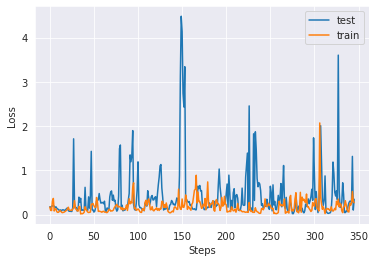

In [25]:
# exit()
%matplotlib inline
sns.set_style('darkgrid')
plt.plot(range(losses_test.shape[0]), losses_test, label="test");
plt.plot(range(losses_train.shape[0]), losses_train, label="train");
plt.legend();
plt.xlabel("Steps");
plt.ylabel("Loss");

### MSE (For Regression)

In [26]:
for i in range(6):
    print(f"MSE for Dimension {i+1}: {torch.mean(torch.tensor(mse[i])):.4f}")

MSE for Dimension 1: 1.5109
MSE for Dimension 2: 1.3061
MSE for Dimension 3: 0.8641
MSE for Dimension 4: 1.1307
MSE for Dimension 5: 1.2936
MSE for Dimension 6: 2.4056


### Classification Metrics

In [27]:
for i in range(4):
    print(f"Classification Report for Dimension {6+i}:")
    print(classification_report(labels[i], preds[i]))
    print("\n\n")

Classification Report for Dimension 6:
              precision    recall  f1-score   support

         0.0       0.61      0.30      0.40      6826
         1.0       0.24      0.23      0.24      2121
         2.0       0.26      0.29      0.27      1717
         3.0       0.01      0.12      0.02       408

    accuracy                           0.27     11072
   macro avg       0.28      0.23      0.23     11072
weighted avg       0.46      0.27      0.33     11072




Classification Report for Dimension 7:
              precision    recall  f1-score   support

         0.0       0.80      0.68      0.73      8096
         1.0       0.01      0.01      0.01       469
         2.0       0.15      0.08      0.10       790
         3.0       0.12      0.18      0.14      1717

    accuracy                           0.53     11072
   macro avg       0.27      0.24      0.25     11072
weighted avg       0.61      0.53      0.56     11072




Classification Report for Dimension 8:
       